In [1]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch
import scipy
from torch.utils.data import TensorDataset as TData
from torch.utils.data import DataLoader as DL
import matplotlib.pyplot as plt
import pickle
import os

import torch
import torch.nn as nn
import torch.optim as optim

from mne.filter import filter_data
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

root = '/content/drive/MyDrive/Longhorn Neurotech/LHNT_pickles/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preprocessing**

In [167]:
# Base folder containing the files
# right_session_folder = os.path.join(root, "alan_f_right/session_1")

# Initialize a dictionary to store the loaded signals
right_eeg_data = {}

# Iterate through files labeled in increments of two
for j in range(1, 5):
  right_session_folder = os.path.join(root, f"alan_f_right/session_{j}")
  for i in range(2, 21, 2):  # Adjust the range as needed
      file_path = os.path.join(right_session_folder, f"right_{i}.pkl")

      # Check if the file exists
      if os.path.exists(file_path):
          with open(file_path, "rb") as file:
              data = pickle.load(file)
              right_eeg_data[f"right_{j}_{i}"] = data  # Store the data with the corresponding label
      else:
          print(f"File not found: {file_path}")
          break  # Stop if the file sequence ends

# Print summary of loaded data
print(f"Loaded {len(right_eeg_data)} EEG signals.")
for label, signal in right_eeg_data.items():
    print(f"{label}: Type = {type(signal)}, Size = {len(signal) if hasattr(signal, '__len__') else 'N/A'}")


Loaded 40 EEG signals.
right_1_2: Type = <class 'tuple'>, Size = 2
right_1_4: Type = <class 'tuple'>, Size = 2
right_1_6: Type = <class 'tuple'>, Size = 2
right_1_8: Type = <class 'tuple'>, Size = 2
right_1_10: Type = <class 'tuple'>, Size = 2
right_1_12: Type = <class 'tuple'>, Size = 2
right_1_14: Type = <class 'tuple'>, Size = 2
right_1_16: Type = <class 'tuple'>, Size = 2
right_1_18: Type = <class 'tuple'>, Size = 2
right_1_20: Type = <class 'tuple'>, Size = 2
right_2_2: Type = <class 'tuple'>, Size = 2
right_2_4: Type = <class 'tuple'>, Size = 2
right_2_6: Type = <class 'tuple'>, Size = 2
right_2_8: Type = <class 'tuple'>, Size = 2
right_2_10: Type = <class 'tuple'>, Size = 2
right_2_12: Type = <class 'tuple'>, Size = 2
right_2_14: Type = <class 'tuple'>, Size = 2
right_2_16: Type = <class 'tuple'>, Size = 2
right_2_18: Type = <class 'tuple'>, Size = 2
right_2_20: Type = <class 'tuple'>, Size = 2
right_3_2: Type = <class 'tuple'>, Size = 2
right_3_4: Type = <class 'tuple'>, Size =

In [168]:
# Base folder containing the files
# left_session_folder = os.path.join(root, "alan_f_left/session_1")

# Initialize a dictionary to store the loaded signals
left_eeg_data = {}

for j in range(1, 5):
  left_session_folder = os.path.join(root, f"alan_f_left/session_{j}")
  # Iterate through files labeled in increments of two
  for i in range(1, 20, 2):  # Adjust the range as needed
      file_path = os.path.join(left_session_folder, f"left_{i}.pkl")

      # Check if the file exists
      if os.path.exists(file_path):
          with open(file_path, "rb") as file:
              data = pickle.load(file)
              left_eeg_data[f"left_{j}_{i}"] = data  # Store the data with the corresponding label
      else:
          print(f"File not found: {file_path}")
          break  # Stop if the file sequence ends

# Print summary of loaded data
print(f"Loaded {len(left_eeg_data)} EEG signals.")
for label, signal in left_eeg_data.items():
    print(f"{label}: Type = {type(signal)}, Size = {len(signal) if hasattr(signal, '__len__') else 'N/A'}")


Loaded 40 EEG signals.
left_1_1: Type = <class 'tuple'>, Size = 2
left_1_3: Type = <class 'tuple'>, Size = 2
left_1_5: Type = <class 'tuple'>, Size = 2
left_1_7: Type = <class 'tuple'>, Size = 2
left_1_9: Type = <class 'tuple'>, Size = 2
left_1_11: Type = <class 'tuple'>, Size = 2
left_1_13: Type = <class 'tuple'>, Size = 2
left_1_15: Type = <class 'tuple'>, Size = 2
left_1_17: Type = <class 'tuple'>, Size = 2
left_1_19: Type = <class 'tuple'>, Size = 2
left_2_1: Type = <class 'tuple'>, Size = 2
left_2_3: Type = <class 'tuple'>, Size = 2
left_2_5: Type = <class 'tuple'>, Size = 2
left_2_7: Type = <class 'tuple'>, Size = 2
left_2_9: Type = <class 'tuple'>, Size = 2
left_2_11: Type = <class 'tuple'>, Size = 2
left_2_13: Type = <class 'tuple'>, Size = 2
left_2_15: Type = <class 'tuple'>, Size = 2
left_2_17: Type = <class 'tuple'>, Size = 2
left_2_19: Type = <class 'tuple'>, Size = 2
left_3_1: Type = <class 'tuple'>, Size = 2
left_3_3: Type = <class 'tuple'>, Size = 2
left_3_5: Type = <cla

In [169]:
# Inspect the contents of one tuple
example_label = "left_1_1"
example_tuple = left_eeg_data[example_label]

print(f"{example_label} - Element 0: Type = {type(example_tuple[0])}, Content = {example_tuple[0]}")
print(f"{example_label} - Element 1: Type = {type(example_tuple[1])}, Content = {example_tuple[1]}")


left_1_1 - Element 0: Type = <class 'numpy.ndarray'>, Content = [[ 1.07494118e-01  1.16981031e-01  1.25534254e-01 ...  5.25463008e-10
   5.25463017e-10  5.25463008e-10]
 [ 6.37435343e+02  6.39591051e+02  6.61951532e+02 ...  2.03435023e+02
   2.01283768e+02  2.01690832e+02]
 [ 4.70954531e-01  7.39187233e+00  1.19185613e+01 ... -9.66871075e+00
  -8.48860013e+00 -1.08858048e+01]
 ...
 [ 1.07494118e-01  1.16981031e-01  1.25534254e-01 ...  5.25463008e-10
   5.25463017e-10  5.25463008e-10]
 [ 3.11900760e+02  3.02135437e+02  2.94692560e+02 ...  6.59457267e+01
   5.76878637e+01  5.75658806e+01]
 [ 7.94149748e+00  7.37285207e+00  8.81192056e+00 ... -7.29059665e+00
   5.85543683e+00  8.26233830e+00]]
left_1_1 - Element 1: Type = <class 'dict'>, Content = {'First Name': 'Alan', 'Last Name': 'Fletcher', 'EID': 'agf687', 'Stimulant Use': '0 mg', 'Meal Size': 'Medium meal', 'Meal Description': '2 4 inch pancakes', 'Exercised': 'no', 'Exercise Description': 'N/A'}


In [170]:
right_signal_data = {label: signal[0] for label, signal in right_eeg_data.items()}
right_metadata = {label: signal[1] for label, signal in right_eeg_data.items()}

# Inspect extracted signal data and metadata
for label, signal in right_signal_data.items():
    print(f"{label}: Signal shape = {signal.shape}")


right_1_2: Signal shape = (16, 875)
right_1_4: Signal shape = (16, 875)
right_1_6: Signal shape = (16, 875)
right_1_8: Signal shape = (16, 875)
right_1_10: Signal shape = (16, 875)
right_1_12: Signal shape = (16, 875)
right_1_14: Signal shape = (16, 875)
right_1_16: Signal shape = (16, 875)
right_1_18: Signal shape = (16, 875)
right_1_20: Signal shape = (16, 875)
right_2_2: Signal shape = (16, 875)
right_2_4: Signal shape = (16, 875)
right_2_6: Signal shape = (16, 875)
right_2_8: Signal shape = (16, 875)
right_2_10: Signal shape = (16, 875)
right_2_12: Signal shape = (16, 875)
right_2_14: Signal shape = (16, 875)
right_2_16: Signal shape = (16, 875)
right_2_18: Signal shape = (16, 875)
right_2_20: Signal shape = (16, 875)
right_3_2: Signal shape = (16, 875)
right_3_4: Signal shape = (16, 875)
right_3_6: Signal shape = (16, 875)
right_3_8: Signal shape = (16, 875)
right_3_10: Signal shape = (16, 875)
right_3_12: Signal shape = (16, 875)
right_3_14: Signal shape = (16, 875)
right_3_16: S

In [171]:
left_signal_data = {label: signal[0] for label, signal in left_eeg_data.items()}
metadata = {label: signal[1] for label, signal in left_eeg_data.items()}

# Inspect extracted signal data and metadata
for label, signal in left_signal_data.items():
    print(f"{label}: Signal shape = {signal.shape}")


left_1_1: Signal shape = (16, 875)
left_1_3: Signal shape = (16, 875)
left_1_5: Signal shape = (16, 875)
left_1_7: Signal shape = (16, 875)
left_1_9: Signal shape = (16, 875)
left_1_11: Signal shape = (16, 875)
left_1_13: Signal shape = (16, 875)
left_1_15: Signal shape = (16, 875)
left_1_17: Signal shape = (16, 875)
left_1_19: Signal shape = (16, 875)
left_2_1: Signal shape = (16, 875)
left_2_3: Signal shape = (16, 875)
left_2_5: Signal shape = (16, 875)
left_2_7: Signal shape = (16, 875)
left_2_9: Signal shape = (16, 875)
left_2_11: Signal shape = (16, 875)
left_2_13: Signal shape = (16, 875)
left_2_15: Signal shape = (16, 875)
left_2_17: Signal shape = (16, 875)
left_2_19: Signal shape = (16, 875)
left_3_1: Signal shape = (16, 875)
left_3_3: Signal shape = (16, 875)
left_3_5: Signal shape = (16, 875)
left_3_7: Signal shape = (16, 875)
left_3_9: Signal shape = (16, 875)
left_3_11: Signal shape = (16, 875)
left_3_13: Signal shape = (16, 875)
left_3_15: Signal shape = (16, 875)
left_3_

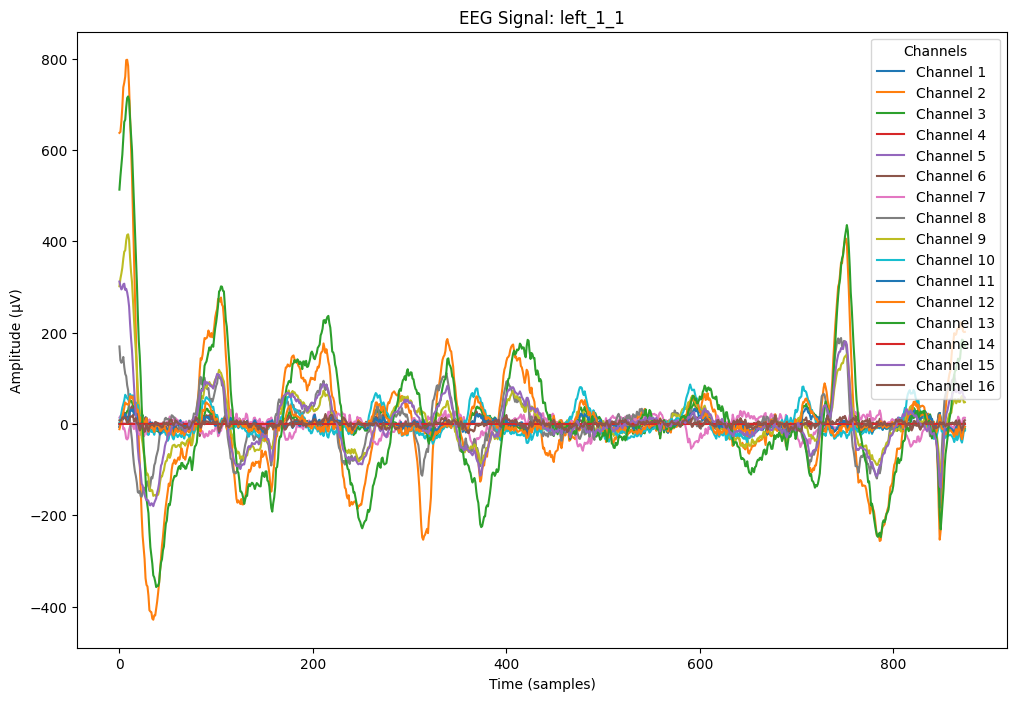

In [172]:
import matplotlib.pyplot as plt

label = "left_1_1"  # Change this to the specific signal you want to visualize
signal = left_signal_data[label]

plt.figure(figsize=(12, 8))

# Plot each channel with a unique label
for i in range(signal.shape[0]):  # Iterate through channels
    plt.plot(signal[i], label=f"Channel {i+1}")  # Label each channel

plt.title(f"EEG Signal: {label}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.legend(title="Channels")  # Add a legend with a title
plt.show()


In [173]:
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler

def baseline_correction(signal):
    """
    Removes baseline offset by subtracting the mean of each channel.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).

    Returns:
        np.ndarray: Baseline-corrected signal.
    """
    return signal - np.mean(signal, axis=1, keepdims=True)


def bandpass_filter(signal, lowcut=13, highcut=30, fs=125, order=4):
    """
    Band-pass filters the signal for the specified frequency range.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).
        lowcut (float): Lower cutoff frequency (Hz).
        highcut (float): Upper cutoff frequency (Hz).
        fs (float): Sampling rate (Hz).
        order (int): Order of the filter.

    Returns:
        np.ndarray: Band-pass filtered signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal, axis=1)

def normalize_signal(signal):
    """
    Normalizes the signal for each channel (z-score normalization).

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).

    Returns:
        np.ndarray: Normalized signal.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(signal.T).T  # Transpose to normalize each channel

def preprocess_eeg(signal, fs=256):
    """
    Preprocess EEG signal with baseline correction, band-pass filtering, and normalization.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).
        fs (float): Sampling rate (Hz).

    Returns:
        np.ndarray: Preprocessed EEG signal.
    """
    # Step 1: Baseline Correction
    signal_corrected = baseline_correction(signal)

    # Step 2: Band-Pass Filter (Beta Frequencies)
    signal_filtered = bandpass_filter(signal_corrected, lowcut=4, highcut=40, fs=fs)

    # Step 3: Normalization
    signal_normalized = normalize_signal(signal_filtered)

    return signal_normalized


In [174]:
# Preprocess each signal in the dictionary
right_preprocessed_signals = {label: preprocess_eeg(signal, fs=256) for label, signal in right_signal_data.items()}

# Inspect the shapes of the processed signals
for label, signal in right_preprocessed_signals.items():
    print(f"{label}: RIGHT Processed Signal Shape = {signal.shape}")


right_1_2: RIGHT Processed Signal Shape = (16, 875)
right_1_4: RIGHT Processed Signal Shape = (16, 875)
right_1_6: RIGHT Processed Signal Shape = (16, 875)
right_1_8: RIGHT Processed Signal Shape = (16, 875)
right_1_10: RIGHT Processed Signal Shape = (16, 875)
right_1_12: RIGHT Processed Signal Shape = (16, 875)
right_1_14: RIGHT Processed Signal Shape = (16, 875)
right_1_16: RIGHT Processed Signal Shape = (16, 875)
right_1_18: RIGHT Processed Signal Shape = (16, 875)
right_1_20: RIGHT Processed Signal Shape = (16, 875)
right_2_2: RIGHT Processed Signal Shape = (16, 875)
right_2_4: RIGHT Processed Signal Shape = (16, 875)
right_2_6: RIGHT Processed Signal Shape = (16, 875)
right_2_8: RIGHT Processed Signal Shape = (16, 875)
right_2_10: RIGHT Processed Signal Shape = (16, 875)
right_2_12: RIGHT Processed Signal Shape = (16, 875)
right_2_14: RIGHT Processed Signal Shape = (16, 875)
right_2_16: RIGHT Processed Signal Shape = (16, 875)
right_2_18: RIGHT Processed Signal Shape = (16, 875)
r

In [175]:
# Preprocess each signal in the dictionary
left_preprocessed_signals = {label: preprocess_eeg(signal, fs=256) for label, signal in left_signal_data.items()}

# Inspect the shapes of the processed signals
for label, signal in left_preprocessed_signals.items():
    print(f"{label}: LEFT Processed Signal Shape = {signal.shape}")


left_1_1: LEFT Processed Signal Shape = (16, 875)
left_1_3: LEFT Processed Signal Shape = (16, 875)
left_1_5: LEFT Processed Signal Shape = (16, 875)
left_1_7: LEFT Processed Signal Shape = (16, 875)
left_1_9: LEFT Processed Signal Shape = (16, 875)
left_1_11: LEFT Processed Signal Shape = (16, 875)
left_1_13: LEFT Processed Signal Shape = (16, 875)
left_1_15: LEFT Processed Signal Shape = (16, 875)
left_1_17: LEFT Processed Signal Shape = (16, 875)
left_1_19: LEFT Processed Signal Shape = (16, 875)
left_2_1: LEFT Processed Signal Shape = (16, 875)
left_2_3: LEFT Processed Signal Shape = (16, 875)
left_2_5: LEFT Processed Signal Shape = (16, 875)
left_2_7: LEFT Processed Signal Shape = (16, 875)
left_2_9: LEFT Processed Signal Shape = (16, 875)
left_2_11: LEFT Processed Signal Shape = (16, 875)
left_2_13: LEFT Processed Signal Shape = (16, 875)
left_2_15: LEFT Processed Signal Shape = (16, 875)
left_2_17: LEFT Processed Signal Shape = (16, 875)
left_2_19: LEFT Processed Signal Shape = 

In [250]:
def sliding_window_augmentation(data, labels, window_size=80, stride=60):
    """
    Apply sliding window to already EMD-processed data

    Args:
    data: numpy array of shape (n_samples, n_channels*n_imfs, time_steps)
    labels: numpy array of shape (n_samples,)
    window_size: size of sliding window
    stride: step size for sliding window

    Returns:
    augmented_data, augmented_labels
    """
    n_samples, n_features, time_steps = data.shape
    n_windows = (time_steps - window_size) // stride + 1

    augmented_data = np.zeros((n_samples * n_windows, n_features, window_size))
    augmented_labels = np.zeros(n_samples * n_windows, dtype=labels.dtype)

    idx = 0
    for i in range(n_samples):
        for j in range(n_windows):
            start = j * stride
            end = start + window_size
            augmented_data[idx] = data[i, :, start:end]
            augmented_labels[idx] = labels[i]
            idx += 1

    return augmented_data, augmented_labels

In [251]:
left_labels = np.array([0 for _ in range(len(left_preprocessed_signals))])
right_labels = np.array([1 for _ in range(len(right_preprocessed_signals))])

left, left_labels = sliding_window_augmentation(np.array(list(left_preprocessed_signals.values())), np.array(left_labels))
right, right_labels = sliding_window_augmentation(np.array(list(right_preprocessed_signals.values())), np.array(right_labels))

In [252]:
left.shape, right.shape, left_labels.shape, right_labels.shape

((560, 16, 80), (560, 16, 80), (560,), (560,))

In [253]:
left_labels, right_labels

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [254]:
X = np.concatenate((left, right), axis=0)
X.shape

(1120, 16, 80)

In [255]:
y = np.concatenate((np.zeros(left.shape[0]), np.ones(right.shape[0])), axis=0)
y.shape

(1120,)

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [263]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

###############################################################################
# 2) Flatten Each Trial for the Neural Network
#    The MLP expects 2D input: (n_samples, n_features).
#    We'll flatten channel-time into a single dimension: 16 * 875 = 14000
X_reshaped = X.reshape(len(X), -1)  # shape => (80, 14000)

print("Original X shape:", X.shape)
print("After flattening:", X_reshaped.shape)

###############################################################################
# 3) Train-Test Split
#    Use 80% train, 20% test (16 samples) for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, stratify=y, random_state=42
)
print("Train set:", X_train.shape, "Test set:", X_test.shape)

###############################################################################
# 4) Define a Simple MLP Classifier
#    We'll do 2 hidden layers, (32, 16) just as an example
#    max_iter=300 to allow enough iterations to converge
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

###############################################################################
# 5) (Optional) Cross-validation on the Training Set
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_train, y_train, cv=cv, n_jobs=-1)

print("\nCross-validation accuracy (Train set):", cv_scores)
print("Mean CV accuracy: %.2f ± %.2f" % (cv_scores.mean(), cv_scores.std()))

###############################################################################
# 6) Retrain on the Full Training Set and Evaluate on Test Set
mlp.fit(X_train, y_train)          # Train on entire training set
y_pred = mlp.predict(X_test)       # Predict on test set
test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy:", test_acc)


Original X shape: (1120, 16, 80)
After flattening: (1120, 1280)
Train set: (896, 1280) Test set: (224, 1280)

Cross-validation accuracy (Train set): [0.47777778 0.45555556 0.53333333 0.44444444 0.51111111 0.53333333
 0.51685393 0.51685393 0.4494382  0.48314607]
Mean CV accuracy: 0.49 ± 0.03

Test accuracy: 0.5491071428571429


In [257]:
csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)
lda = LDA()
pipeline = Pipeline([("CSP", csp), ("LDA", lda)])

In [258]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

cv = StratifiedKFold(n_splits=30, shuffle=True)
scores = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Fit pipeline
    pipeline.fit(X_tr, y_tr)

    # Predict
    y_pred = pipeline.predict(X_val)
    scores.append(accuracy_score(y_val, y_pred))

print("CV Scores:", scores)
print("Mean CV:", np.mean(scores))


Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 16 dim * 5.3e+14  max singular value)
    Estimated rank (data): 14
    data: rank 14 computed from 16 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 16 -> 14
Estimating class=0.0 covariance using LEDOIT_WOLF
Done.
Estimating class=1.0 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 16 dim * 5.2e+14  max singular value)
    Estimated rank (data): 14
    data: rank 14 computed from 16 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 16 -> 14
Estimating class=0.0 covariance using LEDOIT_WOLF
Done.
Estimating class=1.0 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 16 dim * 5.3e+14  max singular value)
    Estimated rank (data): 14
    data: rank 14 com

In [262]:
y_pred = pipeline.predict(X_test)  # Predict on test set
test_acc = accuracy_score(y_test, y_pred)  # Compute accuracy

print(y_pred[:20])
print(y_test[:20])

print(f"\nFinal Test Accuracy: {test_acc:.2f}")

ValueError: shapes (4,16) and (1280,) not aligned: 16 (dim 1) != 1280 (dim 0)